# Predição de atrasos em vôos
------------------------

In [1]:
import pandas as pd
import utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('ggplot')
sns.set_palette("icefire")

## Descrição do *dataset*
----------------------

In [2]:
airlines = pd.read_csv('airlines_delay.csv')
airlines['Flight'] = airlines['Flight'].astype('O')
airlines.head(10)

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0
5,3692.0,580.0,60.0,WN,MSY,BHM,4,0
6,1135.0,690.0,239.0,CO,EWR,DFW,4,0
7,1300.0,1210.0,80.0,AA,DFW,MEM,3,0
8,587.0,1295.0,105.0,FL,BWI,GRR,7,0
9,764.0,530.0,108.0,FL,ATL,PBI,3,0


In [3]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539382 entries, 0 to 539381
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Flight       539382 non-null  object 
 1   Time         539382 non-null  float64
 2   Length       539382 non-null  float64
 3   Airline      539382 non-null  object 
 4   AirportFrom  539382 non-null  object 
 5   AirportTo    539382 non-null  object 
 6   DayOfWeek    539382 non-null  int64  
 7   Class        539382 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 32.9+ MB


In [4]:
cat_features = airlines.select_dtypes(include='object').columns.tolist()
num_features = airlines.select_dtypes(include='number').columns.tolist()

print(f'Categorical features: {cat_features}')
print(f'Numerical features: {num_features}')

Categorical features: ['Flight', 'Airline', 'AirportFrom', 'AirportTo']
Numerical features: ['Time', 'Length', 'DayOfWeek', 'Class']


In [5]:
airlines['Class'].value_counts(normalize=True)

0    0.554557
1    0.445443
Name: Class, dtype: float64

- Possui em torno de 55% dos vôos atrasados
- Dados aparentemente suficientemente balanceados

In [6]:
#utils.distribution_plot(airlines, exclude_columns=['AirportFrom', 'AirportTo'])

In [7]:
airlines.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,539382.0,802.728161,278.045546,10.0,565.0,795.0,1035.0,1439.0
Length,539382.0,132.202104,70.117045,0.0,81.0,115.0,162.0,655.0
DayOfWeek,539382.0,3.929666,1.914666,1.0,2.0,4.0,5.0,7.0
Class,539382.0,0.445443,0.497015,0.0,0.0,0.0,1.0,1.0


- Tempo é a hora de saída em minutos
- Distância máxima de 655 km

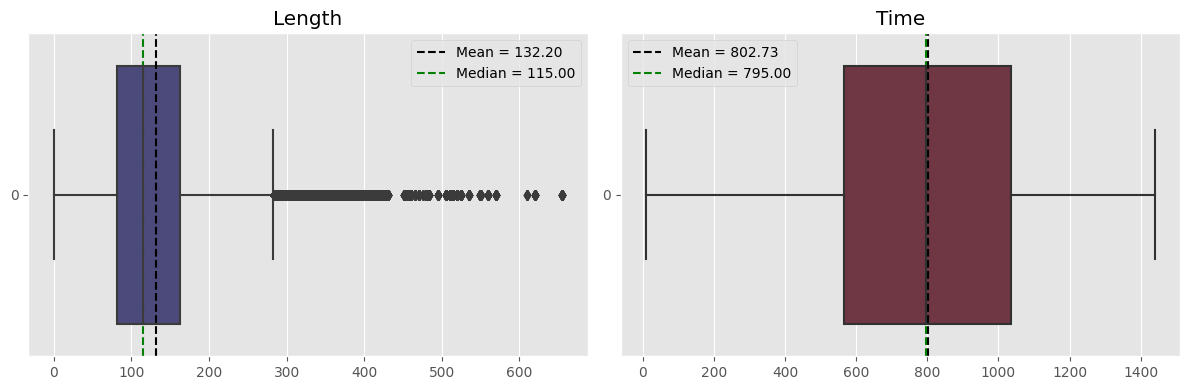

In [8]:
utils.plot_boxplots(airlines, ['Length', 'Time'])

- Bastante *outliers* na distância do vôo. 
- A maioria dos vôos saem entre de 10h da manhã e 17h da tarde.

## Análise Exploratória
-----------

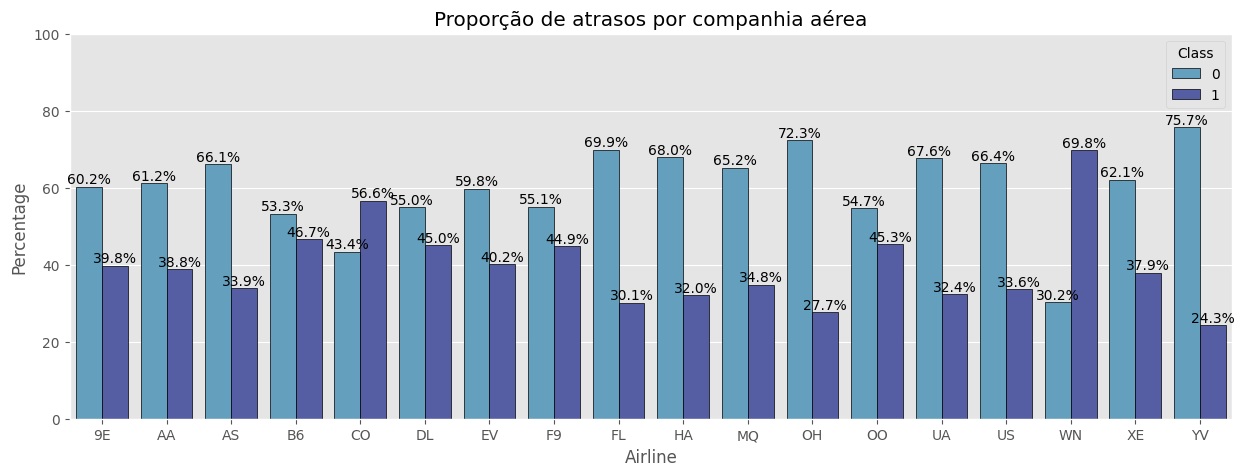

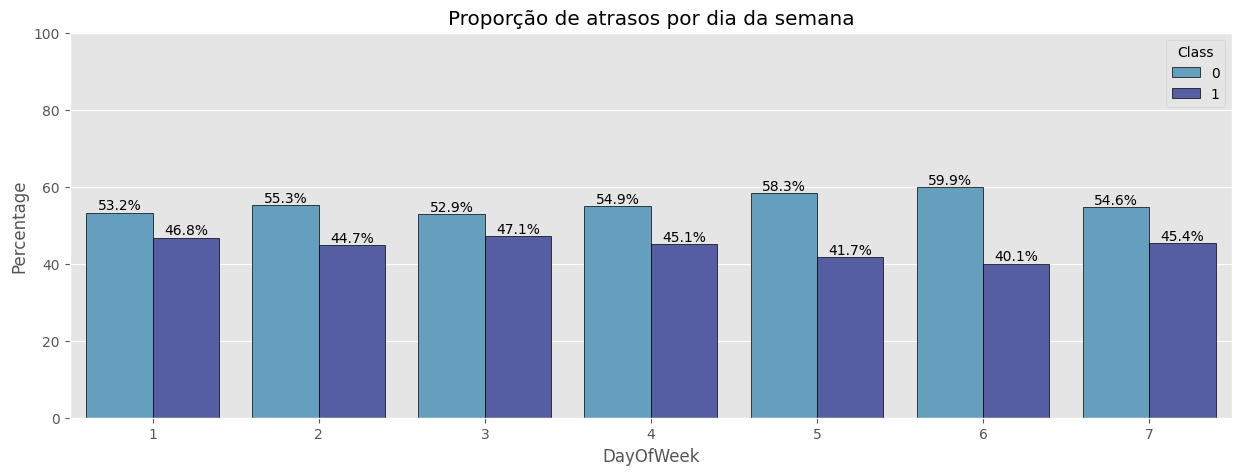

In [9]:
# plot multiple subplots

fig = plt.figure(figsize=(15, 5))
utils.plot_norm_countplot(airlines, category_col='Airline', hue_col='Class', xticks_rotation=0, edgecolor='black', title='Proporção de atrasos por companhia aérea')
fig = plt.figure(figsize=(15, 5))
utils.plot_norm_countplot(airlines, category_col='DayOfWeek', hue_col='Class', xticks_rotation=0, edgecolor='black', title='Proporção de atrasos por dia da semana')

plt.show()


1. Companhias aéreas:
    - A companhia **"WN"** é a campeã de atrasos. Aproximadamente **70%** dos seus vôos estão atrasados.
    - A companhia **"YV"** é a que tem menos atrasos: **24.3%**
2. Dias da semana:
    - Os dias parecem ser similares.
    - Destaque para sexta-feira (sexto dia da semana) que possui aproximadamente 60% dos vôos atrasados.

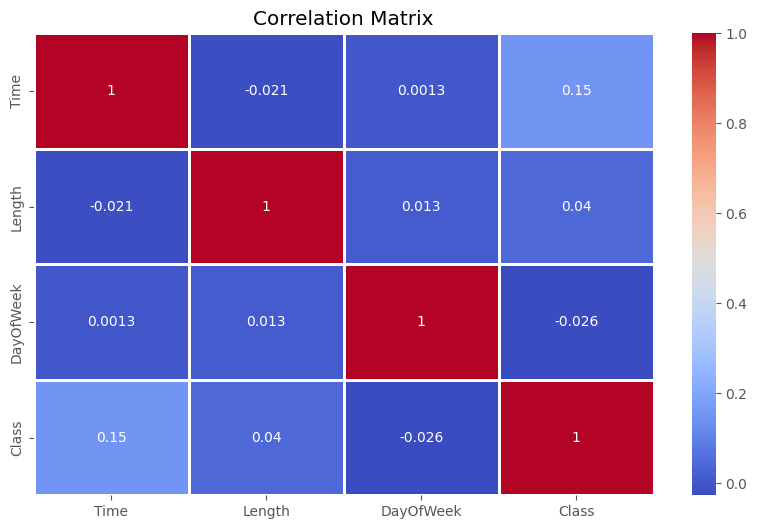

In [10]:
#seaborn correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(airlines.corr(), annot=True, cmap='coolwarm', linewidths=2)
plt.title('Correlation Matrix')
plt.savefig('figures/eda/correlation_matrix.png', dpi=400, bbox_inches='tight')
plt.show()

In [11]:
airlines = airlines.assign(Horario=pd.to_datetime(airlines['Time'], unit='m'))
airlines

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class,Horario
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0,1970-01-01 21:36:00
1,6948.0,360.0,146.0,OO,COS,ORD,4,0,1970-01-01 06:00:00
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0,1970-01-01 19:30:00
3,31.0,1410.0,344.0,US,OGG,PHX,6,0,1970-01-01 23:30:00
4,563.0,692.0,98.0,FL,BMI,ATL,4,0,1970-01-01 11:32:00
...,...,...,...,...,...,...,...,...,...
539377,6973.0,530.0,72.0,OO,GEG,SEA,5,1,1970-01-01 08:50:00
539378,1264.0,560.0,115.0,WN,LAS,DEN,4,1,1970-01-01 09:20:00
539379,5209.0,827.0,74.0,EV,CAE,ATL,2,1,1970-01-01 13:47:00
539380,607.0,715.0,65.0,WN,BWI,BUF,4,1,1970-01-01 11:55:00


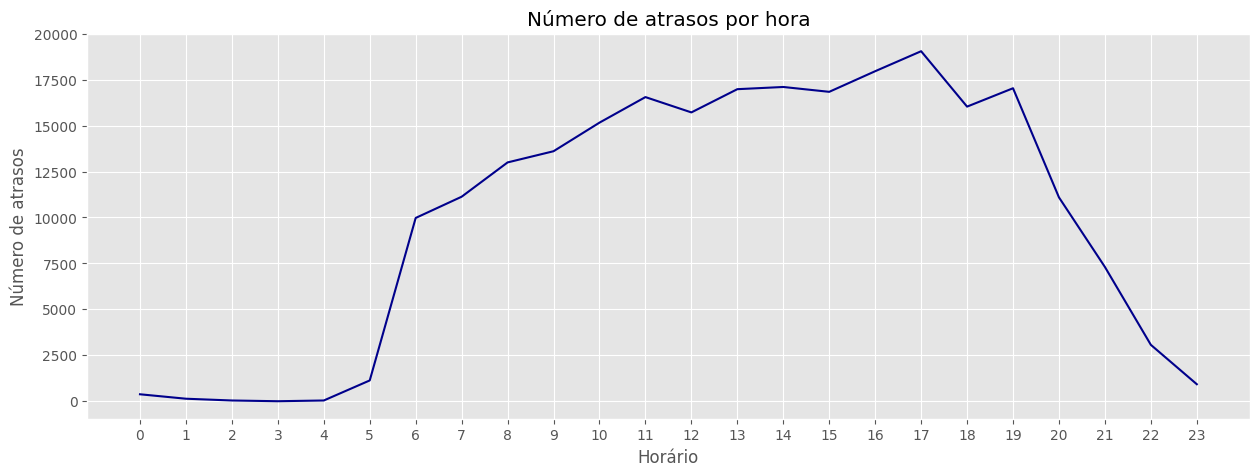

In [12]:
# groupby Horario and count


airlines_delayed = airlines[airlines['Class'] == 1]

#groupby hour

delay_by_hour = airlines_delayed.resample('H', on='Horario')['Class'].count()

#plot

plt.figure(figsize=(15, 5))
sns.lineplot(data=delay_by_hour, x=delay_by_hour.index.hour, y=delay_by_hour.values, color='darkblue')
plt.xlabel('Horário')
plt.ylabel('Número de atrasos')
plt.title('Número de atrasos por hora')
plt.xticks(np.arange(0, 24, 1))

plt.savefig('figures/eda/delay_by_hour.png', dpi=400, bbox_inches='tight')
plt.show()

## Modelagem

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def feature_engineering_preprocessing(data):
    # Step 1: Extracting Date Components
    #data['Year'] = data['Horario'].dt.year
    #data['Month'] = data['Horario'].dt.month
    #data['Day'] = data['Horario'].dt.day
    data['Hour'] = data['Horario'].dt.hour
    data['Minute'] = data['Horario'].dt.minute

    # Step 2: Creating Time-based Features
    data['TimeOfDay'] = pd.cut(data['Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    data['DayOfWeek'] = data['DayOfWeek'].astype('category')

    return data


def compare_algorithms(X, y, algorithms):
    results = []

    # Define the column transformer for ordinal encoding and feature engineering
    numeric_features = ['Time', 'Length']
    categorical_features = ['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_features),
            ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
        ])
    
    # preprocessor for logreg and knn
    preprocessor_logreg_knn = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Iterate over the algorithms
    for algorithm in algorithms:
        if isinstance(algorithm, (DecisionTreeClassifier, RandomForestClassifier)):
            # Create the pipeline for the current algorithm
            pipeline = Pipeline([
                ("preprocessing", preprocessor),
                ("polynomial", PolynomialFeatures(interaction_only=True)),
                ("model", algorithm)
            ])
        elif isinstance(algorithm, (LogisticRegression, KNeighborsClassifier)):
            pipeline = Pipeline([
                ("preprocessing", preprocessor_logreg_knn),
                ("model", algorithm)
            ])

        else:
            print(f"{type(algorithm).__name__} not supported")

        # Perform cross-validation with 6 folds for the current algorithm
        algorithm_results = cross_validate(pipeline, X, y, cv=6,
                                           scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

        # Calculate the mean of evaluation metrics for the current algorithm
        algorithm_metrics = {
            'Model': type(algorithm).__name__,
            'Accuracy': np.mean(algorithm_results['test_accuracy']),
            'Precision': np.mean(algorithm_results['test_precision_macro']),
            'Recall': np.mean(algorithm_results['test_recall_macro']),
            'F1-Score': np.mean(algorithm_results['test_f1_macro'])
        }

        results.append(algorithm_metrics)

    # Create a dataframe to store the evaluation metrics
    metrics_df = pd.DataFrame(results)

    return metrics_df

# Separate the features (X) and target variable (y)
X = airlines.drop("Class", axis=1)
y = airlines["Class"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply feature engineering and preprocessing after the split
X_train = feature_engineering_preprocessing(X_train)

# Define the algorithms to compare
algorithms = [DecisionTreeClassifier(max_depth=5), RandomForestClassifier(n_estimators=100, n_jobs=-1), 
              LogisticRegression(max_iter=1000, n_jobs=-1), KNeighborsClassifier(n_neighbors=5, n_jobs=-1)]

# Compare the algorithms
results = compare_algorithms(X_train, y_train, algorithms)


# Print the dataframe with the evaluation metrics
print(results)


In [ ]:
best_model = results.sort_values(by='F1-Score', ascending=False).iloc[0]

print(f"Best model: {best_model['Model']}")